In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [69]:
def generate_time_series(length=500, time_step=0.1, noise_std=0.05):
    np.random.seed(42)
    t = np.arange(0, length * time_step, time_step)  # Higher resolution time steps
    
    # Base signal (low frequency)
    base_wave = np.sin(2 * np.pi * 0.05 * t)
    
    # Harmonics (higher frequencies)
    harmonic1 = 0.5 * np.sin(2 * np.pi * 0.15 * t)  # 3x base frequency
    harmonic2 = 0.1 * np.sin(2 * np.pi * 0.25 * t)  # 5x base frequency
    harmonic3 = 0.2 * np.sin(2 * np.pi * 0.4 * t)   # 8x base frequency
    
    # Combine waves + optional noise
    series = base_wave + harmonic2 + harmonic3
    series += np.random.normal(0, noise_std, size=series.shape)
    
    #series = np.sin(time) + np.cos(10*time)*0.3 + np.random.normal(0, noise_std, length)  # Sine wave with noise
    return series

In [70]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_dataloader(series, lookback, batch_size, train=True, train_ratio=0.8):
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i:i+lookback])
        y.append(series[i+lookback])
    X, y = np.array(X), np.array(y)

    # Split into train and test
    split_idx = int(len(X) * train_ratio)
    if train:
        dataset = TimeSeriesDataset(X[:split_idx], y[:split_idx])
    else:
        dataset = TimeSeriesDataset(X[split_idx:], y[split_idx:])

    return DataLoader(dataset, batch_size=batch_size, shuffle=train)

In [71]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

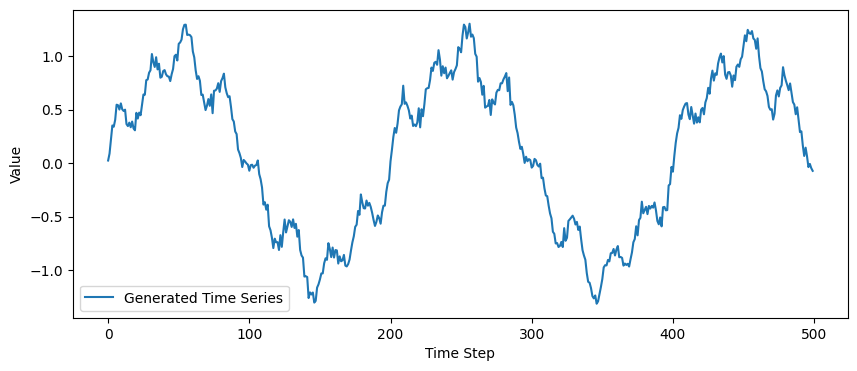

In [72]:
# Generate time series
time_series = generate_time_series()

# Plot generated time series
plt.figure(figsize=(10, 4))
plt.plot(time_series, label="Generated Time Series")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()

# Hyperparameters
lookback = 10
batch_size = 32

# Create DataLoaders
train_loader = create_dataloader(time_series, lookback, batch_size, train=True)
test_loader = create_dataloader(time_series, lookback, batch_size, train=False)

# Instantiate model, loss, and optimizer
model = MLP(lookback)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [73]:
epochs = 300  # Increase training time
for epoch in range(epochs):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {total_loss / len(train_loader):.4f}')

Epoch 0/300, Loss: 0.3701
Epoch 10/300, Loss: 0.0109
Epoch 20/300, Loss: 0.0077
Epoch 30/300, Loss: 0.0065
Epoch 40/300, Loss: 0.0061
Epoch 50/300, Loss: 0.0055
Epoch 60/300, Loss: 0.0052
Epoch 70/300, Loss: 0.0055
Epoch 80/300, Loss: 0.0047
Epoch 90/300, Loss: 0.0047
Epoch 100/300, Loss: 0.0048
Epoch 110/300, Loss: 0.0053
Epoch 120/300, Loss: 0.0048
Epoch 130/300, Loss: 0.0047
Epoch 140/300, Loss: 0.0044
Epoch 150/300, Loss: 0.0042
Epoch 160/300, Loss: 0.0046
Epoch 170/300, Loss: 0.0041
Epoch 180/300, Loss: 0.0047
Epoch 190/300, Loss: 0.0044
Epoch 200/300, Loss: 0.0048
Epoch 210/300, Loss: 0.0045
Epoch 220/300, Loss: 0.0042
Epoch 230/300, Loss: 0.0045
Epoch 240/300, Loss: 0.0045
Epoch 250/300, Loss: 0.0046
Epoch 260/300, Loss: 0.0044
Epoch 270/300, Loss: 0.0046
Epoch 280/300, Loss: 0.0058
Epoch 290/300, Loss: 0.0044


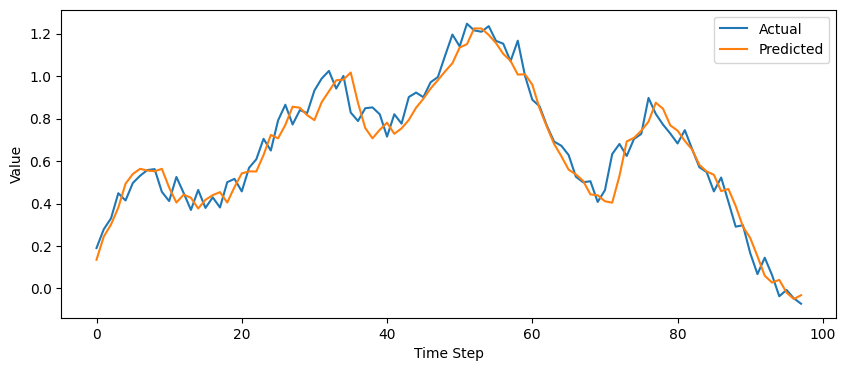

In [74]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        pred = model(batch_X).squeeze()
        predictions.extend(pred.numpy())
        actuals.extend(batch_y.numpy())

# Convert to numpy for plotting
plt.figure(figsize=(10, 4))
plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()

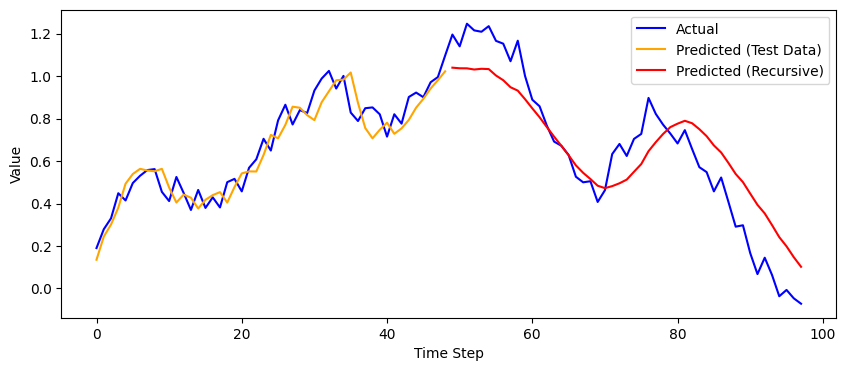

In [75]:
model.eval()

# Extract full test dataset (without shuffling!)
X_test_full, y_test_full = [], []
for batch_X, batch_y in test_loader:
    X_test_full.extend(batch_X.numpy())  # Collect all inputs
    y_test_full.extend(batch_y.numpy())  # Collect all true outputs

X_test_full = np.array(X_test_full)
y_test_full = np.array(y_test_full)

# First half: Predict normally from test data (Orange)
predictions = []
half_point = len(X_test_full) // 2  # Define the halfway point

with torch.no_grad():
    for i in range(half_point):
        input_tensor = torch.tensor(X_test_full[i], dtype=torch.float32).unsqueeze(0)
        pred = model(input_tensor).squeeze().item()
        predictions.append(pred)  # Store predicted value

# Second half: Recursive predictions (Red)
input_seq = list(X_test_full[half_point - 1])  # Start with the last real test input

for i in range(half_point, len(X_test_full)):
    input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0)
    pred = model(input_tensor).squeeze().item()
    
    # Mix with true value to prevent drift
    alpha = 0.1  # Blending factor (adjustable)
    pred = alpha * y_test_full[i] + (1 - alpha) * pred  # Blend prediction with true value

    predictions.append(pred)  # Store predicted value
    
    # Update input sequence (Shift left, append new pred)
    input_seq.pop(0)
    input_seq.append(pred)

# Plot results
plt.figure(figsize=(10, 4))
plt.plot(y_test_full, label="Actual", color="blue")  # True values
plt.plot(range(half_point), predictions[:half_point], label="Predicted (Test Data)", color="orange")  # First half predictions
plt.plot(range(half_point, len(X_test_full)), predictions[half_point:], label="Predicted (Recursive)", color="red")  # Second half predictions
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()